# Pre Processing

In [124]:
import numpy as np
import pandas as pd

In [125]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

In [126]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
data = pd.read_csv("/content/drive/MyDrive/NSL-KDD/KDDTrain+.txt",header=None, names=col_names)
data_test = pd.read_csv("/content/drive/MyDrive/NSL-KDD/KDDTest+.txt",header=None, names=col_names)


In [128]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [129]:
data.drop(['difficulty_level'],axis=1,inplace=True)
data_test.drop(['difficulty_level'],axis=1,inplace=True)
data.shape

(125973, 42)

In [130]:
data['label'].value_counts()
data_test['label'].value_counts()

normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
perl                  2
udpstorm              2
sqlattack             2
loadmodule            2
worm                  2
phf                   2
imap                  1
Name: label, dtype: int64

In [131]:
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [132]:
change_label(data)
change_label(data_test)

In [133]:
data.label.value_counts()

normal    67343
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: label, dtype: int64

In [134]:
data_test.label.value_counts()

normal    9711
Dos       7460
R2L       2885
Probe     2421
U2R         67
Name: label, dtype: int64

In [135]:
data.label.replace({"normal":0, "Dos":1, "Probe":1, "R2L":1, "U2R":1}, inplace=True)
data_test.label.replace({"normal":0, "Dos":1, "Probe":1, "R2L":1, "U2R":1}, inplace=True)

In [136]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


# Encoding

In [137]:
pip install --upgrade category_encoders

In [138]:
import category_encoders
from category_encoders import LeaveOneOutEncoder

In [139]:
features = ["protocol_type", "service", "flag"]
targ_enc = LeaveOneOutEncoder(cols=features)
targ_enc.fit(data[features], data['label'])
    
data = data.join(targ_enc.transform(data[features]).add_suffix('_targ'))
data_test = data_test.join(targ_enc.transform(data_test[features]).add_suffix('_targ'))
    
newdata = data.drop(features, axis=1)
newdata_test = data_test.drop(features, axis=1)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [140]:
newdata.shape

(125973, 42)

# Scaling

In [141]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

In [142]:
numeric_col = newdata.select_dtypes(include='number').columns

In [143]:
rbs_scaler = RobustScaler()
for i in numeric_col:
    arr = newdata[i]
    arr = np.array(arr)
    newdata[i] = rbs_scaler.fit_transform(arr.reshape(len(arr),1))
    arr2 = newdata_test[i]
    arr2 = np.array(arr2)
    newdata_test[i] = rbs_scaler.transform(arr2.reshape(len(arr2),1))

# X Y Dataset 

In [144]:
Y_train = newdata.label
X_train = newdata.drop("label",1)
Y_test = newdata_test.label
X_test = newdata_test.drop("label",1)

In [145]:
X_train.shape

(125973, 41)

In [146]:
Y_train.shape

(125973,)

In [147]:
Y_test.shape

(22544,)

In [148]:
Y_train.head()

0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: label, dtype: float64

# Clean

In [149]:
X_train = X_train.iloc[0:10]
Y_train = Y_train.iloc[0:10]
print(X_train.shape)
print(Y_train.shape)

(10, 41)
(10,)


# Random Forest Model

In [150]:
from sklearn.ensemble import RandomForestClassifier

In [151]:
# model for the binary classification
model = RandomForestClassifier(n_estimators=4)
history = model.fit(X_train, Y_train)

In [152]:
from sklearn.metrics import accuracy_score
# make predictions on the test set
yhat = model.predict(X_test)
yhat_pred=[]
for val in yhat:
    if (val<0.5):
        yhat_pred.append(0)
    else:
        yhat_pred.append(1)
# calculate classification accuracy
acc = accuracy_score(Y_test, yhat)
print(acc)

0.6796043293115684


# Analysis

In [153]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, yhat_pred)

array([[8338, 1373],
       [5850, 6983]])

In [154]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(Y_test, yhat_pred))
print(recall_score(Y_test, yhat_pred))

0.8356869315461943
0.5441440037403569


In [155]:
from sklearn.metrics import f1_score
f1_score(Y_test, yhat_pred)

0.6591155788380764

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.701


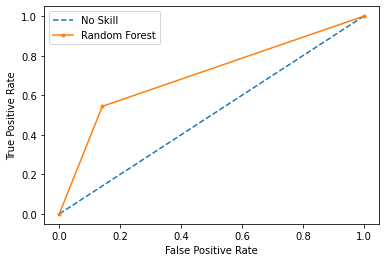

In [156]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as pyplot

ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = model.predict(X_test)
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Random Forest: f1=0.659 auc=0.820


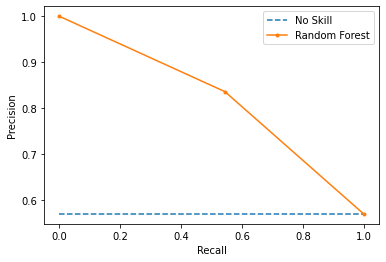

In [157]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# predict probabilities
lr_probs = model.predict(X_test)

lr_precision, lr_recall, _ = precision_recall_curve(Y_test, lr_probs)
lr_f1, lr_auc = f1_score(Y_test, yhat_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Random Forest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()